Тестовое задание yandex


Шаг 1: найдем все битые диалоги и запишем их номера в новую таблицу broken_dialogs

считаем битыми диалоги, у которых:
1) говорит робот или сотрудник, но номер события не равен 2
2) говорит клиент, но номер события не равен 1
3) в одном диалоге, у которого event = 0 (диалог начат)
    +   есть более одной записи
    + временная метка не является минимальной по диалогу
    + значение ссылки предыдущего поста не нулевое
4) в одном диалоге, у которого event = 3 (диалог закончен)
    + есть более одной записи
    + временная метка не является максимальной по диалогу
5) в одном диалоге пристуствуют неуникальные номера клиента


In [ ]:
-- найдем и запишем битые диалоги в новую таблицу
create table if not exists broken_dialogs as 
select DialogID

from ( 
    -- выявляем диалоги, у которых события по логике не совпадают с OfficerID

    select DialogID from DialogsPosts
    where 
        (OfficerID <> 0 and EventType <>2)  -- говорит робот или сотрудник, но событие - не сообщение поддержки
        or (OfficerID=0 and EventType <> 1) -- говорит клиент, но событие этому не соответствует 
    

union 

    -- выявляем уникальные номера битых диалогов, у которых:
    -- event = 0 (диалог начат), но временная метка не минимальная по диалогу или существует номер последнего поста (этого не должно быть)
    -- или event =3 (диалог закончен), но временная метка не максимальная по диалогу
    select distinct DialogID 
    from 
    (select * from DialogsPosts where EventType in (0,3)) as sed -- начало/конец диалога
    left outer join 

    (select DialogID, min(TimeStamp) as min_ts, max(TimeStamp) as max_ts
    from DialogsPosts
    group by DialogID) as mints

    using(DialogID)

    where EventType=0 and
        (TimeStamp <> min_ts or LastPostID is not null)
        or
        EventType =3 and TimeStamp <>max_ts

union

    -- выбираем битые диалоги, у которых имя клиента не уникально 
    -- (среднее значение номера не равно любому из значений)
    select distinct DialogID from 
    DialogsPosts inner join (
        select DialogID, avg(ClientID) as true_client_id
        from DialogsPosts
        group by DialogID) as true_cid using(DialogID)

    where  true_client_id <> ClientID 

union

    -- битые диалоги, которые имеют больше одного начал
    select DialogID
    from(

        select DialogID, EventType
        from DialogsPosts
        where EventType = 0) as only_start_dia

    group by DialogID
    having count(EventType) >1

union 

    -- диалоги, которые имеют больше одного завершений 
    select DialogID
    from(

        select DialogID, EventType
        from DialogsPosts
        where EventType =3) as only_start_dia

    group by DialogID
    having count(EventType) >1
    ) as temp_query
;



Битые диалоги под номерами 1,3, 7, 8, 12

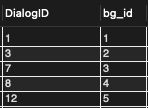

Для каждого «чистого» (т. е. «небитого») диалога рассчитать время решения проблемы клиента и отранжировать диалоги по полученному значению

In [ ]:

select DialogID, dec_time_in_minutes from 
	
    -- вложенный запрос для определения времени, потраченного на весь диалог
    (select DialogID,
	 -- min(TimeStamp)as min_ts, max(TimeStamp) as max_ts, -- строка для проверки правильности расчетов
	TIMESTAMPDIFF(minute, min(TimeStamp),max(TimeStamp)) as dec_time_in_minutes -- считаем разницу между началом
																				-- и концом диалога в минутах
	from DialogsPosts
	group by DialogID

	having DialogID not in 					-- отбираем только чистые диалоги (не битые)
	(select DialogID from broken_dialogs) 
	) as time_diff

-- пересекаем полученные диалоги , отбирая только те, ЧТО РЕШЕНЫ
inner join (select DialogID from DialogsPosts where EventType =3) as only_solved
using(DialogID) 
order by dec_time_in_minutes    -- сортируем по времени решения

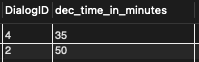

Отдельно вытащим информацию по диалогам:

+ кто решал (робот/человек)
+ сколько человек решало (один/много)
+ какой диалог еще в процессе решения (не завершен)

In [ ]:
select DialogID, who_solve,  
ifnull(is_solved,0) as is_solved, -- заполняем строку нулями, если при объединении появляются пустые значения
ifnull(is_solved_one_person,0) as is_solved_one_person,
ifnull(is_solved_more_one_person,0) as is_solved_many_person
from	
	(-- диалоги, которые решались с участием людей
		select distinct DialogID, 
		"human" as  who_solve
					from DialogsPosts
					where OfficerID>0
					
		union 

		-- диалоги, что решались только роботом
		select distinct DialogId,
		"robot" as  who_solve
		from DialogsPosts

		where DialogId not in (
			select DialogID
			from DialogsPosts
			where OfficerID>0) 
		) as who_solve_table
        
left outer join 
-- те диалоги, что решены
	(select DialogID,
	1 as is_solved
	from DialogsPosts
	where EventType =3 ) as only_solved
using(DialogID) 

left outer join 
-- разделям на диалоги, которые решались/решаются одним человеком или несколькими людьми
	(select DialogID, 
		if(num_persons=1, 1,0) as is_solved_one_person,
		if(num_persons>1, 1,0) as is_solved_more_one_person
		from(
			select DialogID, count(distinct(OfficerID)) as num_persons
			from (
				select DialogID, OfficerID
				from DialogsPosts
				where OfficerID>0
				) as solved_with_human
			group by DialogID
			) as temp
	) as how_many_people
using(DialogID)        


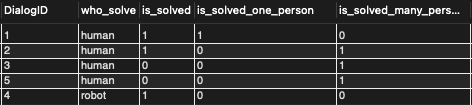

Запишем эту информацию в отдельную таблицу classified_dialogs и из нее организуем запрос по условию:

Разметить диалоги в следующие классы: «решены роботом», «решены с привлечением одного специалиста», «решены с привлечением более чем одного специалиста», «не решены или находятся в процессе решения».

In [ ]:
select * from classified_dialogs;

select DialogID, 
if(is_solved=1 and who_solve="robot", 1,0) as Реш_роботом,
if(is_solved=1 and is_solved_one_person=1, 1,0) as реш_с_привлечением_1_специалиста,
if(is_solved=1 and is_solved_many_person=1, 1,0) as решены_с_привлечением_более_чем_1_специалиста,
if(is_solved=0, 1,0) as не_реш_или_находятся_в_процессе_решения
from classified_dialogs

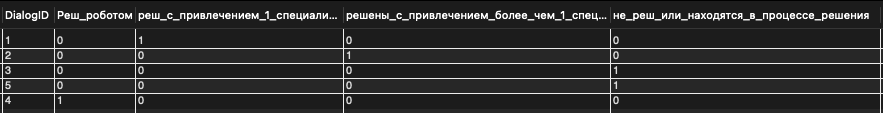

Здесь можно пересечь полученную таблицу с таблицей небитых диалогов, чтобы вывести только чистые по этом запросу
+ (достаточно просто прописать inner join broken_dialogs using(DialogID))

+ я этого делать не буду, в виду ограниченности чистых таблиц (их всего три, см выше), потому что в некоторых столбцах после объединения будут только нули



Найти незакрытые диалоги и отранжировать их по времени нахождения в стадии «решается», выведя наверх самые долго решаемые диалоги.

In [ ]:
select DialogID, dec_time_in_minutes from 
	
    -- вложенный запрос для определения времени, потраченного на весь диалог
    (select DialogID,
	 -- min(TimeStamp)as min_ts, max(TimeStamp) as max_ts, -- строка для проверки правильности расчетов
	TIMESTAMPDIFF(minute, min(TimeStamp),max(TimeStamp)) as dec_time_in_minutes -- считаем разницу между началом
																				-- и концом диалога в минутах
	from DialogsPosts
	group by DialogID) as time_diff
    
    where DialogID in
		(-- выбираем диалоги, которые находятся в процессе решения
		select DialogID from
		(select DialogID, 
		if(is_solved=1 and who_solve="robot", 1,0) as Реш_роботом,
		if(is_solved=1 and is_solved_one_person=1, 1,0) as реш_с_привлечением_1_специалиста,
		if(is_solved=1 and is_solved_many_person=1, 1,0) as решены_с_привлечением_более_чем_1_специалиста,
		if(is_solved=0, 1,0) as не_реш_или_находятся_в_процессе_решения
		from classified_dialogs) as temp

		where не_реш_или_находятся_в_процессе_решения =1)
        
order by dec_time_in_minutes desc

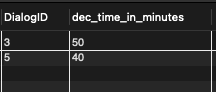

### Метрики, кажущиеся мне интересными:

1) Общее количество диалогов: Эта метрика позволяет оценить общую активность пользователей и объем работы службы поддержки.

2) Среднее время ответа: Рассчитывается как разница между временем получения вопроса или утверждения клиента и временем ответа от специалиста или робота. Позволяет оценить эффективность работы службы поддержки и скорость реагирования на запросы пользователей.

3) Количество диалогов, в которых был подключен специалист: Данная метрика позволяет оценить долю диалогов, требующих вмешательства специалиста, и может быть полезной для планирования загрузки службы поддержки.

4) Среднее количество постов в диалоге: Эта метрика показывает среднее количество постов (вопросов и ответов) в каждом диалоге. Может быть полезна для оценки глубины взаимодействия с пользователями и понимания сложности проблем, с которыми сталкиваются клиенты.

5) Количество закрытых диалогов: Позволяет оценить общую эффективность решения проблем пользователей и завершения диалогов со службой поддержки.

6) Наиболее часто встречающиеся проблемы: Анализ текста сообщений (постов) может помочь выявить наиболее часто встречающиеся проблемы пользователей, что может быть полезно для оптимизации процессов поддержки и предоставления более быстрых решений.

7) Временные пики активности: Анализ временных меток постов может помочь выявить пики активности пользователей и спроса на поддержку, что может быть полезно для планирования ресурсов службы поддержки.

Yandex стажировка


In [ ]:
n = int(input())


In [ ]:
# вспомогательная функция, которая позволяет определить конечность квеста
def is_finite(n, quests):
    visited = [False] * n  # Список посещенных npc
    current_npc = 0  # Индекс текущего npc, с которого начинается квест

    while True:
        if current_npc == -1:   # если текущий npc возвращает -1(награду), то квест завершен
            return True         

        if visited[current_npc]:    # если мы прошли в цикле всех npc  и каждый вернул False, 
                                    # (то есть по индексу вернул элемент False из списка посещенных)
                                    # то квест зациклен
            return False  

        visited[current_npc] = True     # на каждом посещении меняем значение списка на True 
                                        # (то есть отмечаем, что посещение конкретного npc  состоялось)

        if current_npc >= n or quests[current_npc] >= n or quests[current_npc] == current_npc:    # здесь отсекаем некорретные индексы для нашего списка
                                                            # но только ПОСЛЕ проверки двух условий выше
            return False  # Некорректные данные
                                        
        current_npc = quests[current_npc]   # соотв меняем и текущего npc на следующего, к которому он нас отправил

    return False


n = int(input())
quests = list(map(int, input().split()))

# Проверка квестов
if is_finite(n, quests):
    print("Yes")
else:
    print("No")


No


In [ ]:
n= int(input())
npcs = map(int, input().split()) # меняем строку на список целых чисел

flag = False
for npc in npcs:
	if npc == -1: 
		flag = True
		break

if flag: print('Yes')
else: print('No')

Yes


In [ ]:
def is_finite(n,npcs):    
    visited = [False] * n  # Список посещенных npc
    current_npc = 0  # Индекс текущего npc, с которого начинается квест

    while True:
        if current_npc == -1:   # если текущий npc возвращает -1(награду), то квест завершен
            return True
        
        current_npc = visited[current_npc]

n= int(input())
npcs = map(int, input().split()) # меняем строку на список целых чисел

In [ ]:
def is_finite(n,npcs):    
    visited = [False] * n  # Список посещенных npc
    current_npc = 0  # Индекс текущего npc, с которого начинается квест

    result = False
    for npc in npcs:
        if visited[current_npc] == True: break
        if npc == -1: 
            result = True
            break
        visited[current_npc] = True
        current_npc = npc-1
    return result

n= 5 #int(input())
npcs = [2,3,5,-1, 4]
npcs = [2,1,5,-1, 4]
npcs = [2,3,1,1, 4]
npcs = [1,2,3,4,5]
# map(int, input().split()) # меняем строку на список целых чисел

print(('No', 'Yes')[is_finite(n,npcs)])

No


In [ ]:
def calculate_probability(n, k):
    if n % 2 == 1:
        return 1

    if k % 2 == 0:
        p = k // 2
    else:
        p = k

    q = k
    x = (p * q - 1) % 1000000007
    return x

# Примеры тестовых значений
test_cases = [(2, 3), (5, 5)]

for n, k in test_cases:
    result = calculate_probability(n, k)
    print(f"Результат для n={n}, k={k}: {result}")


Результат для n=2, k=3: 8
Результат для n=5, k=5: 1


In [ ]:
def calculate_probability(n, k):
    if n % 2 == 1:
        return 1

    total_outcomes = k**n
    odd_outcomes = (k // 2)**n if k % 2 == 0 else k**n

    x = (odd_outcomes * pow(total_outcomes, 1000000005, 1000000007)) % 1000000007
    return x

# Примеры тестовых значений
test_cases = [(2, 3), (5, 5)]

for n, k in test_cases:
    result = calculate_probability(n, k)
    print(f"Результат для n={n}, k={k}: {result}")


Результат для n=2, k=3: 1
Результат для n=5, k=5: 1


In [ ]:
def calculate_probability(n, k):
    if n % 2 == 1:
        return 1

    total_outcomes = k**n
    odd_outcomes = (k + 1) // 2

    x = (odd_outcomes * pow(total_outcomes, 1000000005, 1000000007)) % 1000000007
    return x

# Примеры тестовых значений
test_cases = [(2, 3), (5, 5)]

for n, k in test_cases:
    result = calculate_probability(n, k)
    print(f"Результат для n={n}, k={k}: {result}")


Результат для n=2, k=3: 222222224
Результат для n=5, k=5: 1


In [ ]:
a,b,c,d = map(int, input().split())
print(((d-b)*c+a, a)[d<=b])

160


### Yandex стажировка Аналитика

    Два игрока по очереди подкидывают монету, вероятность выпадения орла и решки на ней одинаковы. Первый игрок кинул монету 
    n+1 раз, а второй n раз. Посчитайте вероятность того, что у первого игрока выпало строго больше решек, чем у второго.

In [ ]:
n = int(input())



In [ ]:
import pandas as pd

def get_df_prob(num_flips):
    outcomes = []
    for i in range(2 ** num_flips):
        outcome = []
        for j in range(num_flips):
            outcome.append((i >> j) & 1)
        outcomes.append(outcome)
    
    df = pd.DataFrame(outcomes, columns=[f'attempt_{i+1}' for i in range(num_flips)])
    df['num_resh'] = df.sum(axis=1)
    df=df.reset_index().rename(columns={'index' : 'num_att'})
    
    
    return df[['num_att', 'num_resh']]

# Пример использования
num_flips = 3
df1 = get_df_prob(num_flips)
print(df1)


   num_att  num_resh
0        0         0
1        1         1
2        2         1
3        3         2
4        4         1
5        5         2
6        6         2
7        7         3


In [ ]:
def change_to_bin(string):
    if string == 'P': return 1
    else: return 0

In [ ]:
df2 = get_df_prob(2)
df2

,num_att,num_resh
0,0,0
1,1,1
2,2,1
3,3,2


In [ ]:
df1.merge(df2, how='cross')\
    .rename(columns={'num_resh_x': 'Player1', 'num_resh_y': 'Player2'})

,num_att_x,Player1,num_att_y,Player2
0,0,0,0,0
1,0,0,1,1
2,0,0,2,1
3,0,0,3,2
4,1,1,0,0
5,1,1,1,1
6,1,1,2,1
7,1,1,3,2
8,2,1,0,0
9,2,1,1,1


In [ ]:
num_true = df1.merge(df2, how='cross')\
    .rename(columns={'num_resh_x': 'Player1', 'num_resh_y': 'Player2'}).\
    query("Player1>Player2").Player1.count()

num_true

16

In [ ]:
import pandas as pd

def get_df_prob(num_flips):
    outcomes = []
    for i in range(2 ** num_flips):
        outcome = []
        for j in range(num_flips):
            outcome.append((i >> j) & 1)
        outcomes.append(outcome)
    
    df = pd.DataFrame(outcomes, columns=[f'attempt_{i+1}' for i in range(num_flips)])
    df['num_resh'] = df.sum(axis=1)
    df=df.reset_index().rename(columns={'index' : 'num_att'})
    
    
    return df[['num_att', 'num_resh']]

n = 10

df1 = get_df_prob(n+1)
df2 = get_df_prob(n)

num_true = df1.merge(df2, how='cross')\
    .rename(columns={'num_resh_x': 'Player1', 'num_resh_y': 'Player2'}).\
    query("Player1>Player2").Player1.count()

num_comb = 2**(n+1) * 2**n

result = num_true/num_comb

df1.merge(df2, how='cross')\
    .rename(columns={'num_resh_x': 'Player1', 'num_resh_y': 'Player2'}).\
    query("Player1>Player2").Player1.count() / 2097152


0.5

        Будем называть "странной суммой" последовательности чисел 
        t1, … ,tk  значение алгебраической суммы 
        t1−t2+t3−...+(−1)^(k−1)*tk.

        Для данного массива целых чисел определить, существует ли в нём непустой подотрезок с указанным значением "странной суммы".

        Формат ввода
        В первой строке два целых числа:
        n количество элементов массива ,  
        x желаемое значение "странной суммы" для подотрезка.

        Во второй строке 
        n целых чисел 
        a1,…,an через пробел - массив, в котором мы ищем такой подотрезок.

        Формат вывода
        Строка "YES", если в заданном массиве существует подотрезок с указанной "странной суммой", и "NO", если нет.

In [ ]:
def check_strange_sum(n, x, array):
    prefix_sums = [0] * (n + 1)
    for i in range(1, n + 1):
        prefix_sums[i] = prefix_sums[i - 1] + array[i - 1]

    for i in range(n):
        for j in range(i + 1, n + 1):
            subarray_sum = prefix_sums[j] - prefix_sums[i]
            if subarray_sum == x:
                return "YES"
    return "NO"

# Чтение входных данных
n, x = map(int, input().split())
array = list(map(int, input().split()))

# Проверка наличия подотрезка с указанной "странной суммой"
result = check_strange_sum(n, x, array)
print(result)


NO


In [ ]:
#test1
first = '6 5'
sec = '6 -4 7 12 9 4'

        Задание на знание языка SQL.

        Дана таблица с логом показов рекламы в ленте:
        feed_events (
        uuid: str,
        timestamp: int,
        event: str
        ), где uuid — id пользователя, timestamp — Unix-время события, event — тип события. В поле event может быть одно из трех значений: 'open' — открытие ленты, 'show' — показ рекламы, 'click' — клик в рекламу.
        Выведите 10 uuid'ов c наибольшим CTR (CTR (Click Through Rate) - отношение числа кликов в рекламу к числу показов рекламы). Для каждого uuid'a отберите только те события, которые были во времени после первого залогированного для него события 'open'.
        Результат должен быть отсортирован в порядке убывания CTR (округлите его до двух знаков после запятой). Если у разных uuid'ов CTR совпадает, упорядочьте их лексикографически.
        Запрос должен быть написан на диалекте SQLite3.

In [ ]:
-- основной запрос получения uuid и CTR, округленного до двух знаков после запятой
select uuid,
round(clicked_num/showed_num,2) as ctr 
from
( -- вложенный запрос для определения числа показов рекламы для каждого пользователя с учетом того, что
-- эти события стоят ПОСЛЕ открытия, т.е временная метка показа больше временной метки открытия
	select uuid,
	count(event) as showed_num
	from events 
	left outer join
	( -- вложенный запрос для определения временной метки открытия ленты для каждого пользователя
		select distinct(uuid),
		min(opened_time)
		over(partition by uuid) as min_opened_time
	from(
		select uuid, 
		timestamp as opened_time,
		event
		from events
		where event = 'open'
		order by timestamp
		) as temp
	) as opened

	using(uuid)
	where event = 'show' and timestamp> min_opened_time
	group by uuid
) as showed_q

inner  join 

(-- вложенный запрос определения числа кликов рекламы для каждого пользователя с учетом аналогичного условия - после открытия ленты
select uuid,
count(event) as clicked_num
from events 
left outer join
( -- вложенный запрос для определения временной метки открытия ленты для каждого пользователя
		select distinct(uuid),
		min(opened_time)
		over(partition by uuid) as min_opened_time
	from(
		select uuid, 
		timestamp as opened_time,
		event
		from events
		where event = 'open'
		order by timestamp
		) as temp
	) as opened

using(uuid)
where event = 'click' and timestamp> min_opened_time
group by uuid
) as clicked_q

using(uuid)

order by ctr desc,  uuid  -- упорядочить по убыванию CTR, а в случае совпадения значений - по лексикографич знач имен пользователей
limit 10 -- вывести первые 10

![image.png](attachment:image.png)

In [ ]:
def make_equal(f, s):
    n = len(f)
    steps = []
    
    # Открываем все символы f
    steps.append((1, n))
    
    for i in range(n):
        # Заменяем символы fi
        steps.append((i+1, i+1))
        
        # Заменяем символы si
        if i > 0:
            steps.append((1, i))
        
    # Проверяем, равны ли строки
    if f == s:
        return steps
        
    return "Невозможно"



# test2
f = "101"
s = "010"


result = make_equal(f, s)

if result != "Невозможно":
    for step in result:
        print(f"Индексы: {step[0]}-{step[1]}")
else:
    print(result)

Невозможно


In [ ]:
f= '101'
s='010'

fl = [1,0,1]
sl = [0,1,0]

# индексы замены для f от 1 до 3
# индексы замены для s от 1 до 3 кроме индексов для f 

from random import randint

l = randint(1,3)
if l==3: r= 3
else: r= randint(l+1,3)

print('Индексы ', l,r)

for i in range()

Индексы  3 3


In [ ]:
counter = 0
while fl!=sl:
    for i in range(3):
        for j in range(3):
            if fl[i]!=0: fl[i]=0
            if sl[j]!=0: sl[j]=0

Вам даны две бинарные строки 
f и s одинаковой длины n

Необходимо сделать все элементы этих сток равными 0. 

Со строкой вы можете делать следующую операцию (все три действия считаются как ОДНА операция):

1) Выбрать два индекса l и r (1≤l≤r≤n)
2) Заменить каждый символ в строке f на противоположный, если индекс символа из диапазона i∈[l,r]
3) Заменить каждый символ в строке s на противоположный, если индекс символа из диапазона i∈[1,l)∪(r,n] 

Задача - посчитать количество операций, необходимых для замены всех символов на 0 в обеих строках

In [ ]:
def count_operations(f, s):
    n = len(f)
    operations = 0
    indexes = []

    while '1' in f or '1' in s:
        if f.count('1') == 0:
            # Если в строке f нет символа '1', обновляем все символы в строке s на '0'
            s = ['0'] * n
        else:
            l = f.index('1')
            r = f.index('1') + 1

            # Запоминаем выбранные индексы l и r
            indexes.append((l, r))

            # Заменяем символы в строках f и s на '0' в текущем диапазоне
            f[l:r] = ['0'] * (r - l)
            s[1:l] = ['0'] * (l-r)
            s[r:n] = ['0'] * (n-r)

        operations += 1

    return operations, indexes

# Пример использования
f = list("101")
s = list("010")
operations, indexes = count_operations(f, s)
print(f"Количество операций: {operations}")
print("Выбранные индексы:")
for l, r in indexes:
    print(f"l = {l}, r = {r}")


Количество операций: 2
Выбранные индексы:
l = 0, r = 1
l = 2, r = 3


In [ ]:
def count_operations(f, s):
    n = len(f)
    operations = 0
    indexes = []

    while '1' in f or '1' in s:
        if f.count('1') == 0:
            # Если в строке f нет символа '1', обновляем все символы в строке s на '0'
            s = ['0'] * n
        else:
            l = f.index('1')
            r = f.index('1') + 1

            # Запоминаем выбранные индексы l и r
            indexes.append((l, r))

            # Заменяем символы в строках f и s на '0' в текущем диапазоне
            f[l:r] = ['0'] * (r - l)
            s[1:l] = ['0'] * (l-r)
            s[r:n] = ['0'] * (n-r)

        operations += 1

    return operations, indexes

# получаем входные данные
num_tests = int(input())    # количество тестов

for _ in range(num_tests):  # запускаем цикл проверки тестов
	n = int(input())
	f = list(input())
	s = list(input())
	operations, indexes = count_operations(f, s)
if operations <= n+5:
    print('YES')
    print(operations)
    for elem in indexes:
        print(*elem)
else: print('NO')


YES
3
2 3
3 4


        Перспективный выпускник университета Ян только что успешно справился с технической частью собеседований в Яндекс и уже находится на финишной прямой к тому, чтобы получить заветное приглашение на работу! Дело осталось за малым, нужно всего лишь обсудить детали приглашения и согласовать размер заработной платы. За день до собеседования Ян решил подготовиться к этой важной встрече и сходить на спиритический сеанс, чтобы воззвать к духам бывших сотрудников Яндекса и узнать у них, какую заработную плату им удалось согласовать.

        Во время сеанса Ян смог получить ответ от 
        N
        N бывших сотрудников. Каждый из них сказал ему число – согласованный размер заработной платы. Известно, что полученные значения представляют собой независимые случайные величины, которые получены из одного нормального распределения.

        Так как Ян не любит рисковать, он решил узнать интервал для параметров этого распределения (
        μ
        μ и 
        σ
        σ), чтобы впоследствии, на основе этой информации, он смог выбрать размер заработной платы. Очень важно, чтобы на оценку интервалов для этих параметров можно было положиться с вероятностью 0.95. Также Ян хотел бы, чтобы интервалы для 
        μ
        μ и 
        σ
        σ были симметричными по возможности (см. Примечания).

        Помогите Яну найти левую и правую границы этих интервалов.

![image.png](attachment:image.png)


Ввод	Вывод

6

40000 200663 142690 48560 40000 242628

25275.446 212904.887

0.000 186836.389

8

235032 40000 255446 115200 40000 40000 40000 53368

25525.694 179235.806

18385.917 165473.252


9

100000 100000 100000 100000 100000 100000 100000 100000 100000

100000.000 100000.000

0.000 0.000

![image.png](attachment:image.png)

In [ ]:
25275.446- 212904.887

-187629.441

In [ ]:
t= [12.706, 4.302, 3.182, 2.776, 2.507, 2.446, 2.3646, 2.306, 2.2622, 2.2281, 2.201, 2.1788, 2.1604, 2.1448, 2.1314, 2.1190, 2.1098, 2.1009, 2.0930]



In [ ]:
n = 6
values = list(map(int,'40000 200663 142690 48560 40000 242628'.split()))
values

[40000, 200663, 142690, 48560, 40000, 242628]

In [ ]:
sred = sum(values)/n

In [ ]:
from statistics import variance

In [1]:
19*18/2


171.0